torch.Size([512, 512])


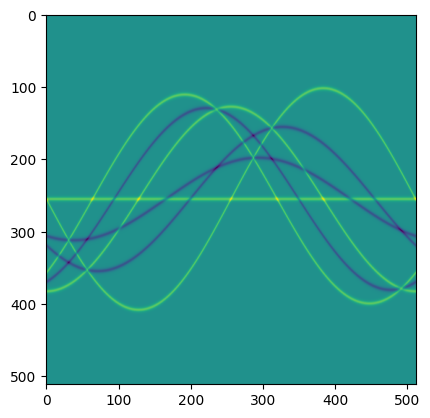

In [4]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import numpy as np
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import torchvision.transforms.functional as f


np.random.seed(42)

NUM_STEPS=512

scale = 200
def compute_ect(x, v, ei=None):
    nh = x @ v
    lin = torch.linspace(-1, 1, NUM_STEPS).view(-1, 1, 1)
    ecc =  torch.nn.functional.sigmoid(scale * torch.sub(lin, nh))*(1- torch.nn.functional.sigmoid(scale * torch.sub(lin, nh)))
    ecc = ecc.sum(axis=1)
    if ei is not None:
        eh = nh[ei].mean(axis=0)
        eccedge = torch.nn.functional.sigmoid(scale * torch.sub(lin, eh))*(1- torch.nn.functional.sigmoid(scale * torch.sub(lin, eh)))
        eccedge = eccedge.sum(axis=1)
        ecc -= eccedge
    return ecc

v = torch.vstack(
    [
        torch.sin(torch.linspace(0, 2*torch.pi, NUM_STEPS)),
        torch.cos(torch.linspace(0, 2*torch.pi, NUM_STEPS)),
    ]
)

x = torch.tensor([
                    [.6,0],
                    [0.0,.5],
                    [-.4,.4],
                    [0,0]
                ])
ei = torch.tensor([[0,1,2],
                   [1,2,0],], dtype = torch.long)


ect = compute_ect(x,v,ei=ei)

plt.imshow(ect)


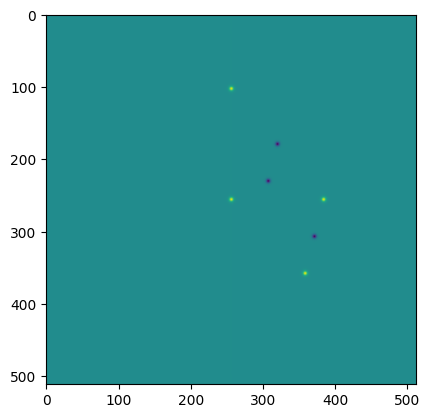

In [18]:
from skimage.transform import iradon

sinogram = ect.numpy()
theta = torch.linspace(0, 360, NUM_STEPS).numpy()

reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')*100

plt.imshow(reconstruction_fbp*100)
plt.show()

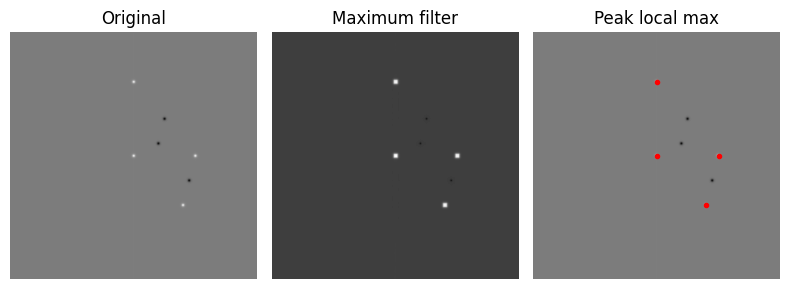

In [19]:
# Local peak detection

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

im = img_as_float(reconstruction_fbp)

# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(im, size=5, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im, min_distance=20,threshold_rel=.1)

# display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()


In [42]:
# Peak intensities
ect[coordinates[:,0],coordinates[:,1]]


# x = torch.tensor([
#                     [.6,0],
#                     [0.0,.5],
#                     [-.4,.4],
#                     [0,0]])


# Vertex coordinates
lin = torch.linspace(-1, 1, NUM_STEPS).view(-1, 1, 1)
x_hat = torch.vstack([
    lin[512-coordinates[:,0]].squeeze(),lin[coordinates[:,1]].squeeze()
]).T
x_hat

tensor([[ 0.0020,  0.0020],
        [ 0.0020,  0.5029],
        [ 0.6008,  0.0020],
        [-0.3973,  0.4012]])

In [52]:
import itertools

# Reconstruct adjacency matrix

recon_ect = []

for x_hat_i in x_hat:
    recon_ect.append(compute_ect(x_hat_i,v))


adj = torch.zeros((4,4))

for i in range(4):
    for j in range(4):
        ect = compute_ect((x_hat[i]+x_hat[j])/2,v)
        rec = torch.tensor(iradon(ect.numpy(), theta=theta, filter_name='ramp'),dtype=torch.float)

        adj[i,j] = -1* (rec * reconstruction_fbp).sum()
print(adj)


torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
tensor([[-2.5717,  0.0105, -0.0230,  0.0107],
        [ 0.0105, -2.5011,  2.5418,  2.5260],
        [-0.0230,  2.5418, -2.5903,  2.5630],
        [ 0.0107,  2.5260,  2.5630, -2.5342]])


In [55]:
adj[adj<1]=0
adj[adj>1]=1

In [57]:
torch.nonzero(adj)

tensor([[1, 2],
        [1, 3],
        [2, 1],
        [2, 3],
        [3, 1],
        [3, 2]])

In [58]:
x_hat

tensor([[ 0.0020,  0.0020],
        [ 0.0020,  0.5029],
        [ 0.6008,  0.0020],
        [-0.3973,  0.4012]])

In [59]:
x

tensor([[ 0.6000,  0.0000],
        [ 0.0000,  0.5000],
        [-0.4000,  0.4000],
        [ 0.0000,  0.0000]])

In [60]:
ei

tensor([[0, 1, 2],
        [1, 2, 0]])

In [ ]:


# import numpy as np
# import matplotlib.pyplot as plt

# from skimage import measure

# r = reconstruction_fbp * 1000

# # # Construct some test data
# # x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
# # r = np.sin(np.exp(np.sin(x)**3 + np.cos(y)**2))


# # Find contours at a constant value of 0.8
# # contours = measure.find_contours(r)

# # # Comparison between image_max and im to find the coordinates of local maxima
# # coordinates = peak_local_max(r, min_distance=50)


# # Display the image and plot all contours found
# fig, ax = plt.subplots()
# ax.imshow(r, cmap=plt.cm.gray)
# # ax.scatter(coordinates[:,0],coordinates[:,1])

# import cv2
# sobelxy = cv2.Sobel(src=r, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection
# plt.imshow(sobelxy)
# plt.show()

# for contour in contours:
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

# ax.axis('image')
# ax.set_xticks([])
# ax.set_yticks([])
# plt.show()




# # # error = reconstruction_fbp - image
# # # print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')


# # # # ####################################################
# # # # ### Reconstruct using filtered backprojection.
# # # # ####################################################

# # # img = torch.zeros(NUM_STEPS,NUM_STEPS)
# # # for slice, theta in zip(ect.T,torch.linspace(0,360,NUM_STEPS)):
# # #     reps = slice.unsqueeze(1).repeat(1, NUM_STEPS).unsqueeze(0)
# # #     img +=f.rotate(reps, theta.item()).squeeze()

# # # plt.imshow(img.numpy())
# # # plt.show()



# # # # m = nn.MaxPool1d(kernel_size=3,stride=1,ceil_mode=True,padding=1)
# # # # output = m(ect.T).T
# # # # out2 = (torch.abs(output) > 1) 
# # # # out = torch.abs(output - ect) == 0.0
# # # # out_full = torch.logical_and(out,out2)
# # # # plt.imshow(out_full)
# # # # plt.show()
# # # # thetas_idx, height_idx  = torch.nonzero(out_full.squeeze(),as_tuple=True)

